# Блок №9 Bootstrap

# Описание эксперимента

Перед вами таблица, где числовая переменная – непрерывная. Задача – сравнить группы двумя способами: бутстрапом и u-тестом

# Описание колонок

+ `value` – значения метрики
+ `experimentVariant` – Вариант теста (Control – контроль, Treatment – тест)

# Задача

1. Сравните результат между тестом и контролем по двум кейсам:
 + Примените бутстрап (с np.mean) и критерий mann-whitney, а потом сравните p-value
 + Примените бутстрап (с np.median) и критерий mann-whitney, а потом сравните p-value.
2. Напишите выводы, которые можно сделать на основе анализа примененных критериев

❗️ Не сравнивайте p-value разных критериев в реальной жизни
1) Это повышает вероятность допустить ошибку I рода и вводит в заблуждение при анализе результатов применения критериев. 
2) Заранее формулируйте гипотезу и подбирайте под нее релевантный статистический критерий в рамках дизайна эксперимента

# Материалы
+ [Данные](https://stepik.org/media/attachments/lesson/396008/hw_bootstrap.csv)
+ [Ноутбук](https://stepik.org/media/attachments/lesson/518903/lecture_2.2_bootstrap.ipynb)

In [41]:
# Импортируем необходимые библиотеки
import numpy as np
import pandas as pd

from scipy.stats import mannwhitneyu # U-критерий Манна-Уитни
from scipy.stats import norm
import scipy.stats as stats

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(rc={'figure.figsize':(16, 6)}, style='whitegrid')
import pylab 

from tqdm.auto import tqdm # библиотека для интерактивного отображения протекания процесса

In [28]:
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(boot_len, replace = True).values
        samples_2 = data_column_2.sample(boot_len, replace = True).values
        
        boot_data.append(statistic(samples_1-samples_2)) # применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    p_1 = norm.cdf(x = 0, loc = np.mean(boot_data), scale = np.std(boot_data))
    p_2 = norm.cdf(x = 0, loc = -np.mean(boot_data), scale = np.std(boot_data))
    p_value = min(p_1, p_2) * 2
        
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
    
    # Визуализация
    plt.hist(pd_boot_data[0], bins = 50)
    
    plt.style.use('ggplot')
    plt.vlines(ci,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "ci": ci, 
            "p_value": p_value}

In [3]:
# Импортируем данные эксперимента
data_ab = pd.read_csv('/home/jupyter-a.stamati-16/Statistic/hw_bootstrap.csv', sep=';', index_col=0)

In [4]:
# Посмотрим на выгрузку данных
data_ab

,value,experimentVariant
1,"10,3804953740268",Control
2,"9,54686666784264",Control
3,"11,0882146509904",Control
4,"10,1472740570122",Control
5,"9,78980767524929",Control
...,...,...
996,1000,Treatment
997,1200,Treatment
998,1500,Treatment
999,2000,Treatment


In [5]:
# Посмотрим на формат данных
data_ab.dtypes

value                object
experimentVariant    object
dtype: object

In [6]:
data_ab.value = data_ab.value.str.replace(',', '.').astype(float)

In [7]:
data_ab.head()

,value,experimentVariant
1,10.380495,Control
2,9.546867,Control
3,11.088215,Control
4,10.147274,Control
5,9.789808,Control


In [8]:
# Снова посмотрим на формат данных
data_ab.dtypes

value                float64
experimentVariant     object
dtype: object

In [9]:
# Построим дополнительный датафрейм, в котором переменную эксперимента переведем в категорибю
result = data_ab.assign(Experiment_Variant=data_ab['experimentVariant'].astype('category'), 
                       Values=data_ab['value'].astype(np.float32))

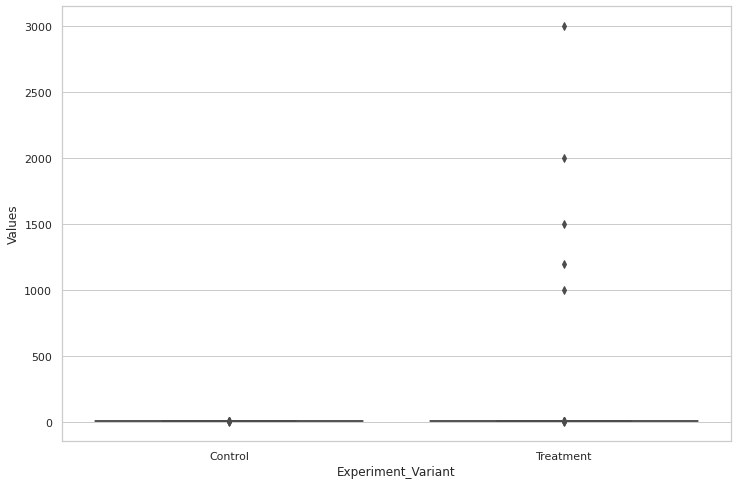

In [10]:
# Построим Boxplot
plt.figure(figsize = [12, 8])
sns_plot = sns.boxplot(x='Experiment_Variant', y='Values', data=result)

In [11]:
data_ab.query('experimentVariant == "Treatment"').describe()

,value
count,500.000000
mean,27.321499
std,186.557011
min,6.436541
25%,9.421968
50%,10.025847
75%,10.675721
max,3000.000000


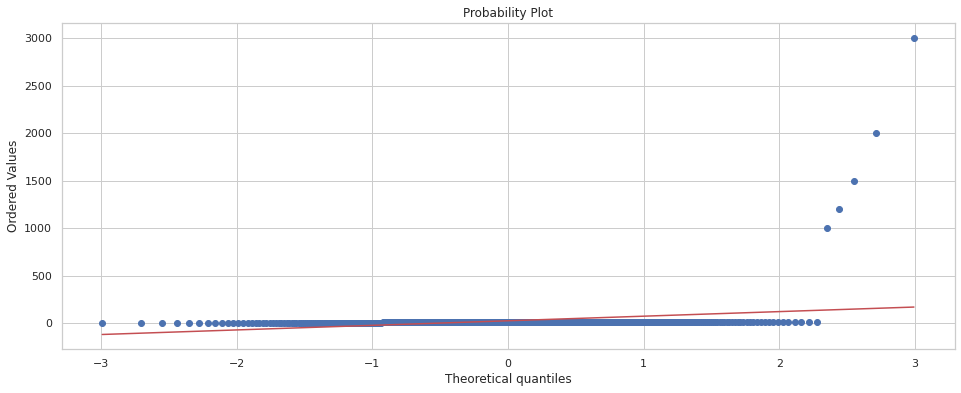

In [12]:
stats.probplot(data_ab.query('experimentVariant == "Treatment"').value, dist="norm", plot=pylab)
pylab.show()

In [13]:
data_ab.query('experimentVariant == "Control"').describe()

,value
count,500.000000
mean,10.026867
std,0.979377
min,6.436541
25%,9.411024
50%,10.018465
75%,10.664879
max,13.130346


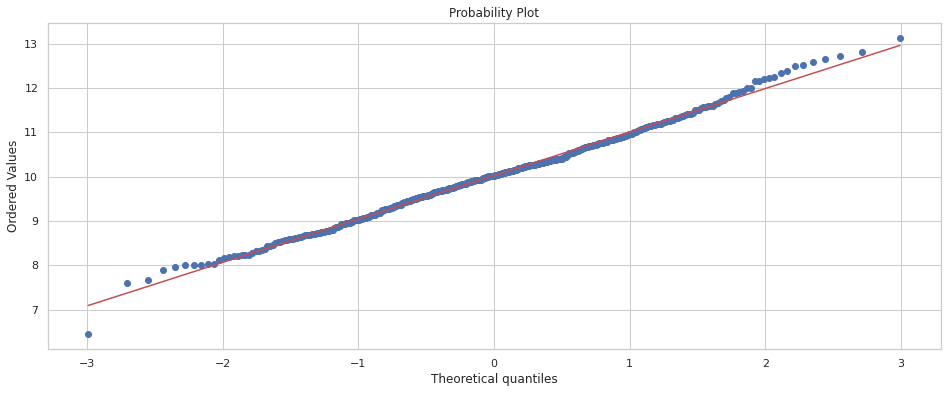

In [14]:
stats.probplot(data_ab.query('experimentVariant == "Control"').value, dist="norm", plot=pylab)
pylab.show()

Как мы видим в группе Treatment есть большие выбросы, которые повлияют на дальнейшие тесты.

### Теперь перейдем к дальнейшему анализу

In [15]:
#  Посмотрим на количество данных в каждой группе
data_ab \
        .groupby('experimentVariant', as_index=False) \
        .agg({'value': 'count'})

,experimentVariant,value
0,Control,500
1,Treatment,500


In [16]:
# Посчитаем среднее для каждой группы
data_ab \
    .groupby('experimentVariant', as_index=False) \
    .agg({'value': 'mean'})

,experimentVariant,value
0,Control,10.026867
1,Treatment,27.321499


In [17]:
# Посчитаем медиану для каждой группы
data_ab \
    .groupby('experimentVariant', as_index=False) \
    .agg({'value': 'median'})

,experimentVariant,value
0,Control,10.018465
1,Treatment,10.025847


In [33]:
# Выделим значения для двух выборок
x = data_ab[data_ab.experimentVariant == 'Treatment'].value
y = data_ab[data_ab.experimentVariant == 'Control'].value

In [30]:
# Посчитаем U-критерий Мана-Уитни
mw = mannwhitneyu(x, y)
print(f'Значение p-value: {mw[1]}')

Значение p-value: 0.8592148582485579


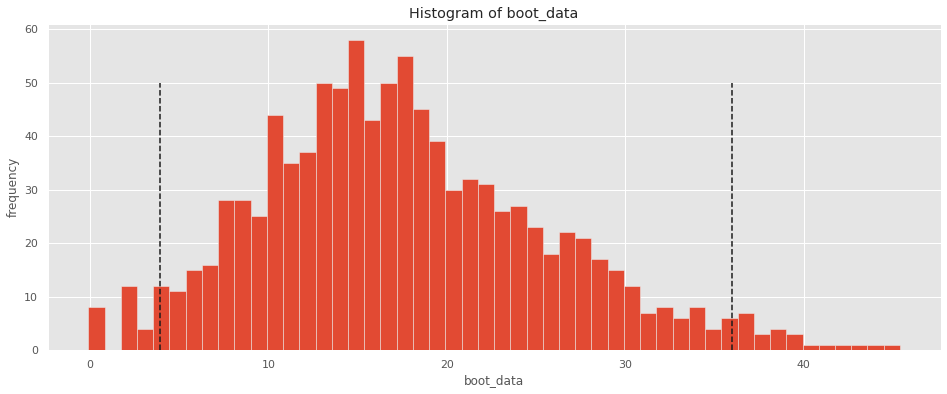

In [31]:
# Проведем бутстрэп-тест для среднего
booted_data_mean = get_bootstrap(
                            x, # числовые значения первой выборки
                            y, # числовые значения второй выборки
                            boot_it = 1000, # количество бутстрэп-подвыборок
                            statistic = np.mean, # интересующая нас статистика
                            bootstrap_conf_level = 0.95 # уровень значимости
                            )

In [20]:
# Значение p-value
print(f'Значение p-value: {booted_data_mean["p_value"]}')

Значение p-value: 0.03887618101849266


In [21]:
# Доверительный интервал
booted_data_mean["ci"]

,0
0.025,3.850332
0.975,36.221089


In [22]:
booted_data_mean["p_value"] < mw[1]

True

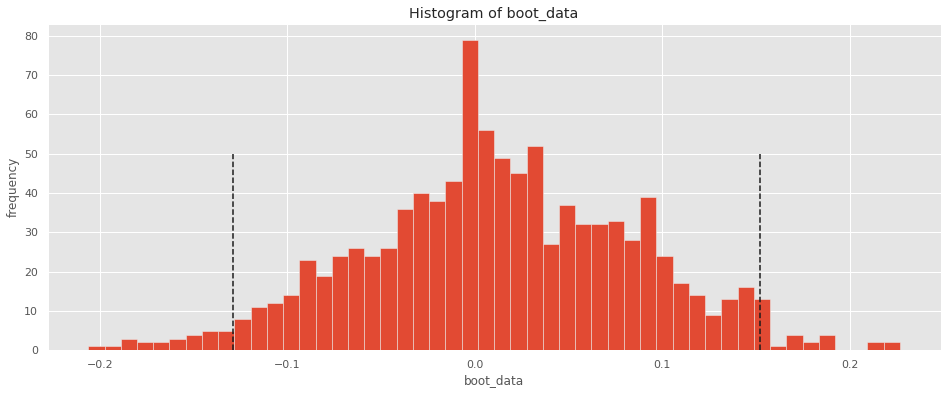

In [32]:
# Проведем бутстрэп-тест для медианы
booted_data_median = get_bootstrap(
                            x, # числовые значения первой выборки
                            y, # числовые значения второй выборки
                            boot_it = 1000, # количество бутстрэп-подвыборок
                            statistic = np.median, # интересующая нас статистика
                            bootstrap_conf_level = 0.95 # уровень значимости
                            )

In [24]:
# Значение p-value
print(f'Значение p-value: {booted_data_median["p_value"]}')

Значение p-value: 0.9164574087385401


In [25]:
# Доверительный интервал
booted_data_median["ci"]

,0
0.025,-0.141796
0.975,0.154955


In [26]:
booted_data_median["p_value"] < mw[1]

False

In [39]:
# # Проделаем более короткий эксперимент 
# res_nw = mannwhitneyu(x, y, alternative = 'two-sided')

# for i in range(10):
#     res_b_npmean = get_bootstrap(x, y)
#     res_b_npmedian = get_bootstrap(x, y, statistic = np.median)
    
#     print(f'Boot mean:{res_b_npmean["p_value"]}, Boot median:{res_b_npmedian["p_value"]}, MW:{res_nw.pvalue}')

# Выводы

* Тестовая выборка имеет большие выбросы, что сильно искажает нам среднее значение
* Применяя бутстрап с оценкой среднего, мы могли бы отклонить нулевую гипотезу о равенстве средних и сделать вывод, что тестовая и контрольная выборка имеют различия
* Однако, тот же бутстрап, но уже по медиане не дает нам отклонить нулевую гипотезу, так как p-value сильно больше 0.05, т.к. здесь проверяется другая гипотеза
* U-критерий Манна-Уитни так же не дал бы нам отклонить нулевую гипотезу. Оценки pvalue так же направлены как у бутстрапирования медианы